In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import csv
import cv2
from typing import Any, Tuple, List

In [72]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, train: bool=False, test: bool=False, valid: bool=False) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = self.get_data(path_to_annot_file, train, test, valid)
        self.transform = transform

    def get_data(self, path_to_annot_file: str, train: bool=False, test: bool=False, valid: bool=False) -> pd.DataFrame:
        data = pd.read_csv(path_to_annot_file, usecols = (0, 2), names = ('path_to_image', 'label'))
        data = data.sample(frac=1).reset_index(drop=True)
        data['label'] = data['label'].apply(lambda label: 0 if label == 'cat' else 1)
        train_size = int(0.8 * data.shape[0])
        test_valid_size = int(0.1 * data.shape[0])
        if train == True:
            data = data.iloc[:train_size, :]
        elif test == True:
            data = data.iloc[train_size:train_size + test_valid_size, :]
        elif valid == True:
            data = data.iloc[train_size + test_valid_size:, :]
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                    torchvision.transforms.RandomHorizontalFlip(p=0.5)])

In [ ]:
train_data = MyDataset(path_to_annot_file='annotation.csv', transform=transforms, train = True)
test_data = MyDataset(path_to_annot_file='annotation.csv', transform=transforms, test = True)
valid_data = MyDataset(path_to_annot_file='annotation.csv', transform=transforms, valid = True)

In [ ]:
len(train_data), len(test_data), len(valid_data)

In [ ]:
train_data.data['label'].value_counts()

In [ ]:

test_data.data['label'].value_counts()

In [ ]:
valid_data.data['label'].value_counts()

In [ ]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                                stride = 2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                stride = 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fully_connect1 = nn.Linear(5408, 10)
        self.fully_connect2 = nn.Linear(10, 1)

    def forward(self, x:torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fully_connect1(output))
        output = torch.nn.Sigmoid()(self.fully_connect2(output))
        return output

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=4, shuffle = True)

In [ ]:
plt.figure(figsize = (10, 5))

for i, sample_batched in enumerate(train_loader):
    if i == 1:
        break
    for j in range(4):
        plt.subplot(1, 4, j + 1)
        plt.title('Cat' if sample_batched[1][j] == 0 else 'Dog')
        plt.imshow(sample_batched[0][j].permute(1, 2, 0).numpy())#[:, :, ::-1])

In [ ]:
parameters = {'lr': [0.001, 0.01, 0.1],
              'batch_size' : [16, 32, 48]}

Epoch 1
Epoch 1 end
Epoch: 1, train_accuracy: 0.6359832635983267, train_loss: 0.6522206664085388
Epoch: 1, valid_accuracy: 0.7196652719665273, valid_loss: 0.612705647945404
Epoch 2
Epoch 2 end
Epoch: 2, train_accuracy: 0.7275104602510468, train_loss: 0.5804209113121033
Epoch: 2, valid_accuracy: 0.7949790794979078, valid_loss: 0.533372163772583
Epoch 3
Epoch 3 end
Epoch: 3, train_accuracy: 0.8059623430962355, train_loss: 0.4990698993206024
Epoch: 3, valid_accuracy: 0.8158995815899581, valid_loss: 0.4631001949310303
Epoch 4
Epoch 4 end
Epoch: 4, train_accuracy: 0.859832635983265, train_loss: 0.43173715472221375
Epoch: 4, valid_accuracy: 0.8410041841004181, valid_loss: 0.41554996371269226
Epoch 5
Epoch 5 end
Epoch: 5, train_accuracy: 0.8708158995815914, train_loss: 0.39095789194107056
Epoch: 5, valid_accuracy: 0.8661087866108786, valid_loss: 0.36992529034614563
Epoch 6
Epoch 6 end
Epoch: 6, train_accuracy: 0.9042887029288718, train_loss: 0.3442859947681427
Epoch: 6, valid_accuracy: 0.8870

RuntimeError: Parent directory c:\Users\RobotComp.ru\Desktop\Lab\lab5\lab5 does not exist.

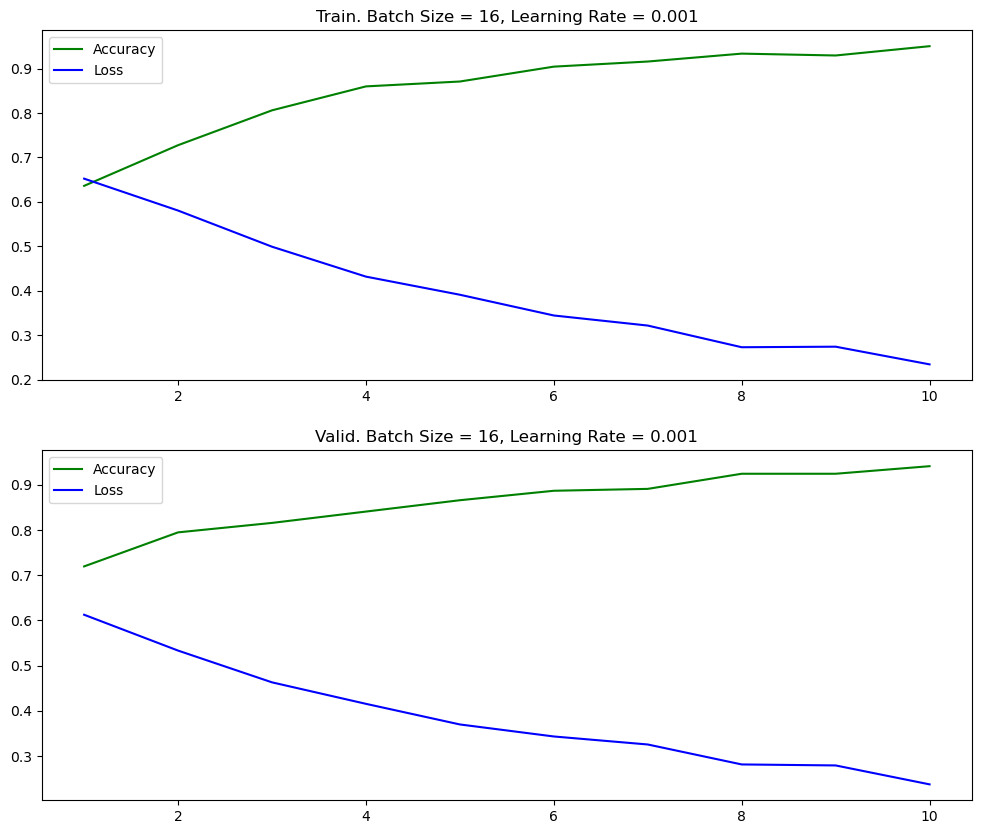

In [73]:
for lr in parameters['lr']:
    for bs in parameters['batch_size']:
        device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        model = CNN().to(device)

        optimizer = optim.Adam(params=model.parameters(), lr=lr)
        criterion = nn.BCELoss(reduction='sum')

        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle = True)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle = False)
        valid_loader = DataLoader(dataset=valid_data, batch_size=bs, shuffle = False)

        epochs = 10

        train_accuracy_values = []
        train_loss_values = []

        val_accuracy_values = []
        val_loss_values = []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}")
            model.train()
            epoch_loss = 0
            epoch_accuracy = 0

            epoch_val_loss = 0
            epoch_val_accuracy = 0

            for data, label in train_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_accuracy += acc / len(train_data)
                epoch_loss += loss / len(train_data)

            model.eval()
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
                acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

                epoch_val_accuracy += acc / len(valid_data)
                epoch_val_loss += loss / len(valid_data)

            val_accuracy_values.append(epoch_val_accuracy)
            val_loss_values.append(epoch_val_loss)

            train_accuracy_values.append(epoch_accuracy)
            train_loss_values.append(epoch_loss)

            print(f"Epoch {epoch + 1} end")

            print('Epoch: {}, train_accuracy: {}, train_loss: {}'.format(epoch + 1, epoch_accuracy, epoch_loss))
            print('Epoch: {}, valid_accuracy: {}, valid_loss: {}'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))

        train_loss_values = [value.cpu().detach().numpy() for value in train_loss_values]
        val_loss_values = [value.cpu().detach().numpy() for value in val_loss_values]

        plt.figure(figsize=(12,10))

        plt.subplot(2, 1, 1)
        plt.title(f"Train. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        plt.subplot(2, 1, 2)
        plt.title(f"Valid. Batch Size = {bs}, Learning Rate = {lr}")
        plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        test_loss = 0
        test_accuracy = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

            acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(len(label))])).sum()

            test_accuracy+=acc / len(test_data)
            test_loss+=loss / len(test_data)

        torch.save(model.state_dict(), os.path.join(os.path.abspath("lab5"), f"bs{bs}_lr{lr}_weight.pt"))

        print('LR: {}, BS: {}, test_accuracy: {}, test_loss: {}'.format(lr, bs, test_accuracy, test_loss))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


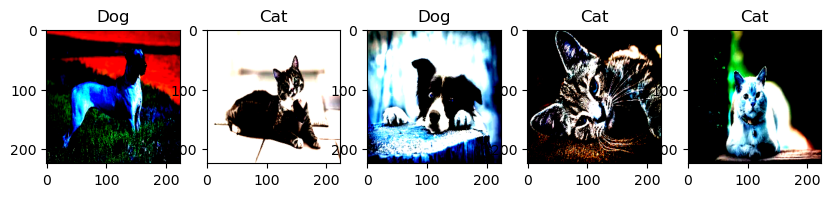

In [74]:
plt.figure(figsize=(10, 5))
import random
for j in range(5):
  index = random.randint(0, 199)
  plt.subplot(1, 5, j + 1)
  plt.title("Cat" if (1 if  model(test_data[index][0].unsqueeze(dim=0).to(device))[0] >= 0.5 else 0) == 0 else "Dog")
  plt.imshow(test_data[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])